<a href="https://colab.research.google.com/github/wolffg7/deeplearning1/blob/main/10_LSTM_CNN_1D_regression_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright
<pre>
You may use and modify this code for research and development purpuses.
Using this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
</pre>

This notebook shows you how to model 1D sequential data with Long Short-Term Memory (LSTM). Let's start with the imports:

In [27]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, LSTM
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

## Exercise: Data preparation
Converting the sequential data to the correct format. In the following function, we creat input (X) and output (Y) mappings from the *timeseries* object. The X numpy array should have a 3D shape: (#num of samples, window_size, *timeseries* dimensions), and Y shape is 2D: (#num of samples, *timeseries* dimension)

In [28]:
def add_noise(timeseries, noise_level):
    noise = np.random.normal(scale=noise_level, size=timeseries.shape)
    noisy_timeseries = timeseries + noise
    return noisy_timeseries

def make_timeseries_instances(timeseries, window_size):
    X = []
    Y = [] 

    for i in range(window_size, len(timeseries)):
        X.append(timeseries[i-window_size:i, :])
        Y.append(timeseries[i, :])
    X = np.array(X)
    Y = np.array(Y) 
    
    return add_noise(X, 0.0), add_noise(Y, 0.0) 



## Exercise: Model definition
Creating the deep learning model, where the input shape is (#num of samples, window_size, timeseries dimensions) and the output shape is (#num of samples,timeseries dimensions). You can create an LSTM or a 1D CNN. 

In [29]:
"""
def make_lstm(window_size, lstm_size, timeseries_dimensions=1):
    model = Sequential() 

    model.add(LSTM(lstm_size, input_shape=(window_size, timeseries_dimensions))) 

    model.add(Dense(timeseries_dimensions))

    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model 
"""

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

def make_lstm(window_size, num_filters, filter_size, timeseries_dimensions=1): 
    model = Sequential()

    model.add(Conv1D(num_filters, filter_size, activation='relu', input_shape=(window_size, timeseries_dimensions)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(timeseries_dimensions))

    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model 

## Training the model
Creating the model and the data, and training and evaluating the model:

In [30]:
def evaluate_timeseries(timeseries, window_size, valid_split=0.15, test_split=0.15):
    lstm_size = 16
    timeseries = np.atleast_2d(timeseries)
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T       # 1D vector -> 2D matrix
    nb_samples, nb_series = timeseries.shape
    model = make_lstm(window_size, lstm_size, nb_series) 
    model.summary()
    X, Y = make_timeseries_instances(timeseries, window_size)
    
    # train-validation-test split
    valid_size = int(nb_samples*(1-test_split-valid_split))
    test_size = int(nb_samples*(1-test_split))
    X_train, Y_train = X[:valid_size], Y[:valid_size]
    X_valid, Y_valid = X[valid_size:test_size], Y[valid_size:test_size]
    X_test, Y_test   = X[test_size:], Y[test_size:]
    
    model.fit(X_train, Y_train, epochs=50, batch_size=16, validation_data=(X_valid, Y_valid), verbose=2)
    
    preds   = model.predict(X_test)

    return Y_test, preds   


We create some example data:

In [31]:
lp 	= np.linspace(-10*np.pi,10*np.pi,1000)
X 	= np.sin(lp)*3+np.cos(lp*2)+np.sin(np.pi/2+lp*4)*1.5+np.log(np.abs(lp))
window_size = 20

targets, preds = evaluate_timeseries(X, window_size)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 20, 16)            32        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 10, 16)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 160)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 161       
                                                                 
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
44/44 - 1s - loss: 9.0181 - mae: 2.5259 - val_loss: 6.4995 - val_mae: 2.1949 - 1s/epoch - 27ms/step
Epoch 2/50


## Simple evaluation
At the end we plot the target values and the predictions:

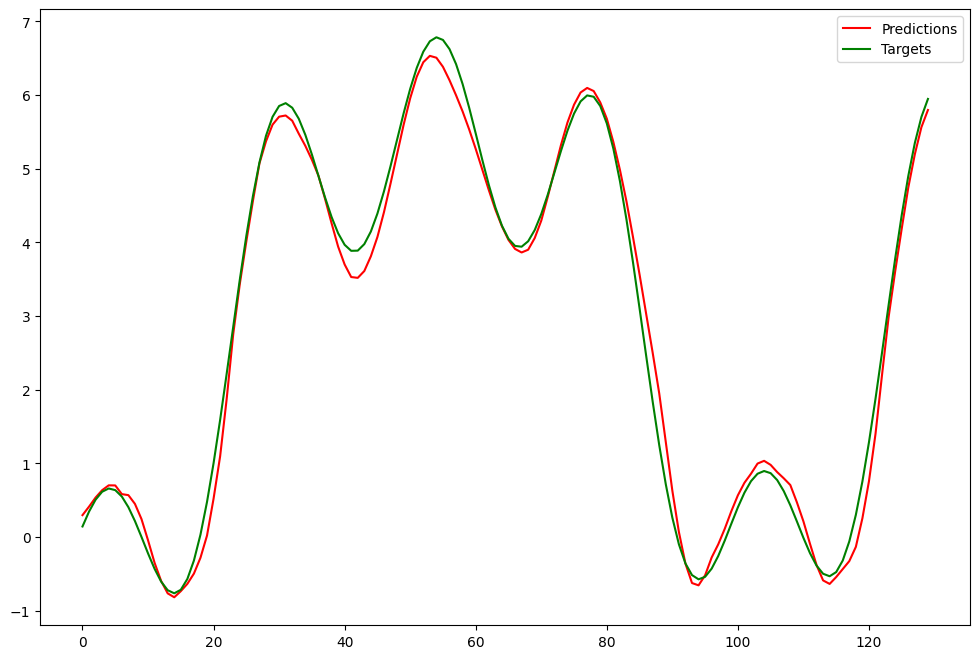

In [32]:
plt.figure(figsize=(12,8))
plt.plot(preds, color='r', label="Predictions")
plt.plot(targets, color='g', label="Targets")
plt.legend()